<a href="https://colab.research.google.com/github/aiboyko/saudi_aramco_data_technathon/blob/main/siren_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
import os


import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [2]:
!pip install tqdm
from tqdm.notebook import tqdm_notebook

In [3]:
# Importing drive method from colab for accessing google drive
from google.colab import drive
import glob

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

Specify the path to the data:

In [7]:
rock_name = 'Normal_1_0.5'
drive_path = '/content/drive/My Drive/rock/'

data_path = drive_path+rock_name+'/' 

tresh = 127
data3d = (loadmat(data_path+rock_name+'.mat')["ctImage"] > tresh).astype(np.float)

In [8]:
save_path = data_path + 'results_siren/'

# Model

In [6]:
class SIREN(torch.nn.Module):
    def __init__(self, N, n_layers, hid_dim, inp_dim, out_dim=1, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.N = float(N)
        if n_layers > 1:
            layers = [torch.nn.Linear(inp_dim, hid_dim)]
            layers.extend([torch.nn.Linear(hid_dim, hid_dim) for _ in range(n_layers-2)])
            layers.append(torch.nn.Linear(hid_dim, out_dim))
        else:
            layers = [torch.nn.Linear(inp_dim, out_dim)]

        self.layers = torch.nn.ModuleList(layers)

    def forward(self, x):
        x = x/self.N
        for l in self.layers[:-1]:
            x = l(x)
            x = torch.sin(x)
        return self.layers[-1](x)



In [9]:
def weights_init_siren(m, c=6):
    if isinstance(m, torch.nn.Linear):
        inp_dim = m.weight.shape[0]
        torch.nn.init.uniform_(m.weight, -np.sqrt(c/inp_dim), np.sqrt(c/inp_dim))
        torch.nn.init.zeros_(m.bias)

In [10]:
def train(model, dataloader, data, L, n_epochs=100):
    losses = []
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(100,601, 300), gamma=.1)

    # optimizer = torch.optim.Adam(params=md.parameters(), lr=lr)

    for epoch in tqdm_notebook(range(3*n_epochs)):
        for x in dataloader:
            optimizer.zero_grad()
            indices = torch.stack(x, dim=1).squeeze().T
            #print(data.shape)
            #print(indices.T.shape)
            y_goal = data[list(indices.T)]
            y_predicted = model(indices.float().to(device)).sigmoid()
            loss = L(y_predicted.squeeze(-1), y_goal.float()) 
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach())
        scheduler.step()
    return losses

# Dataset

In [11]:
class DicreteDataset(Dataset):
    def __init__(self, shape):
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
        indices = np.unravel_index(idx, self.shape)
        return indices


class SliceDataset(Dataset):
    def __init__(self, shape, mask):
        super().__init__()
        self.shape = shape
        self.mask = mask
        self.indices = np.arange(np.prod(shape))[mask.flatten()]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        indices = np.unravel_index(idx, self.shape)
        return indices

In [12]:
# Create masked dataset, 4 slices in each dimension
k = 4
N_slices_approx = 4
data = data3d[::k,::k, ::k]

Nx, Ny, Nz = data.shape
x = np.arange(Nx)
y = np.arange(Ny)
z = np.arange(Nz)

xx, yy, zz = np.meshgrid(x, y, z)

N = np.prod(xx.shape)

mask = np.zeros_like(data, dtype=np.bool)

# select slices for training
selection = np.arange(Nx+1,step=Nx//N_slices_approx)[:-1,None]
selection_rand = selection+np.random.randint((Nx//N_slices_approx)//10,size=(selection.shape[0], 3))
selection_rand[0] = selection[0]
selection_rand[-1] = selection[-1]

mask[selection_rand[:,0]] = True 
mask[:, selection_rand[:,1]] = True
mask[:, :, selection_rand[:,2]] = True

ds_slices = SliceDataset(data.shape, mask)


# given data
torch_data = torch.from_numpy(data).to(device)

# Training

In [13]:
md = SIREN(N = torch_data.shape[0],n_layers=10, hid_dim=256, inp_dim=3, out_dim=1, omega_0=150)

md.apply(lambda x: weights_init_siren(x, c=6))
md = md.to(device)
for p in md.parameters():
    p.data *= md.omega_0
    break

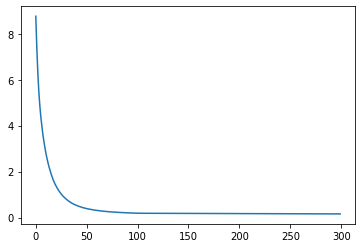

In [14]:
torch_data = torch.from_numpy(data).to(device)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2**20,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)
L = torch.nn.BCELoss()

n_epochs = 100
losses = train(md, dl, torch_data, L, n_epochs=n_epochs)

plt.plot(losses)

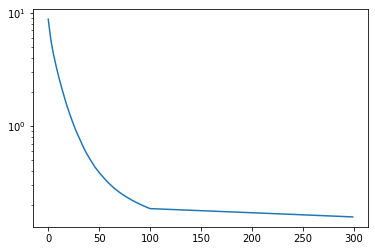

In [15]:
plt.semilogy(losses)

# Visulalization

In [16]:
# for smaller data
idx_full = np.concatenate([xx[:,:,:,None], yy[:,:,:,None], zz[:,:,:,None]], axis=-1)
idx_full_torch = torch.Tensor(idx_full).float()

splitted_idx = torch.split(idx_full_torch, 1)
res_list = []
for t in splitted_idx:
    res_list.append(md(t.to(device)).data.cpu().sigmoid().numpy().squeeze(-1))

res_full = np.concatenate(res_list, axis=0)

In [17]:
def plot_selected_slices(selected_idx, res_full, data, mask, axis='z', idx_plot=1):
    res = res_full[selected_idx]

    #plt.suptitle(axis+' slice', fontsize=14)
    plt.subplot(3, 2, 2*idx_plot-1)
    plt.imshow(res[:, :], cmap='gray')
    plt.title('generated ' + axis + ' slice')

    

    data_sel = data[selected_idx]
    '''
    mask_sel = mask[selected_idx]
    new_mask = np.zeros((mask_sel.shape[0], mask_sel.shape[1], 3), dtype=int)
    new_mask[mask_sel] = np.array([254,0,0])
    masked_data = new_mask.copy()
    data_rgb = np.zeros((data_sel.shape[0],data_sel.shape[1],3),dtype=int)
    data_rgb[data_sel==1,:] = np.array([255,255,255])
    masked_data[new_mask[:,:,0] == 0] = data_rgb[new_mask[:,:,0] == 0]
    '''

    plt.subplot(3, 2, 2*idx_plot)
    plt.imshow(data_sel, cmap='gray')
    plt.title('real ' + axis + ' slice')

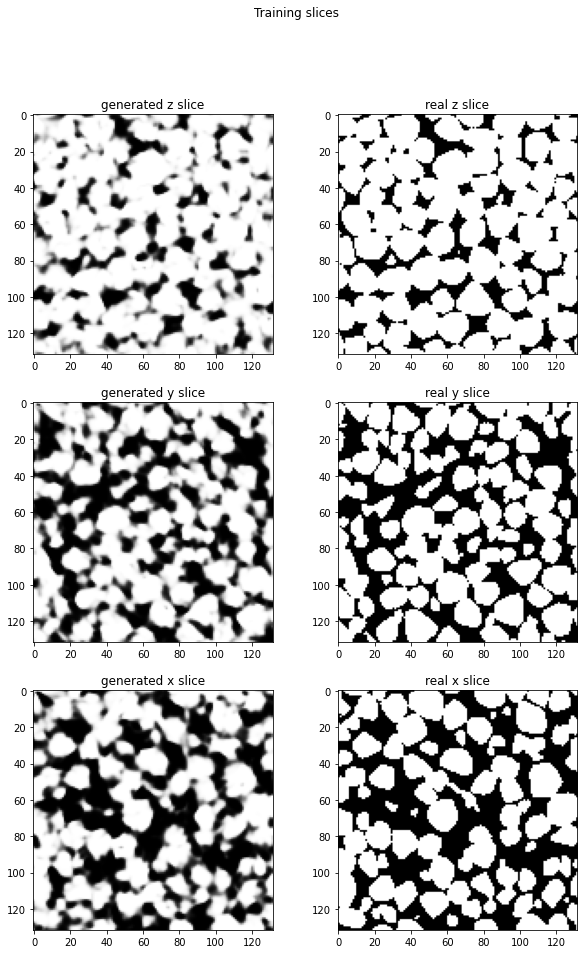

In [18]:
sel_slice = 0

plt.figure(figsize=(10,15))
plt.suptitle('Training slices')

sel = (slice(None), slice(None), sel_slice)
plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, idx_plot=1)

sel = (slice(None), sel_slice, slice(None))
plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, axis='y', idx_plot=2)

sel = (sel_slice, slice(None), slice(None))
plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, axis='x', idx_plot=3)

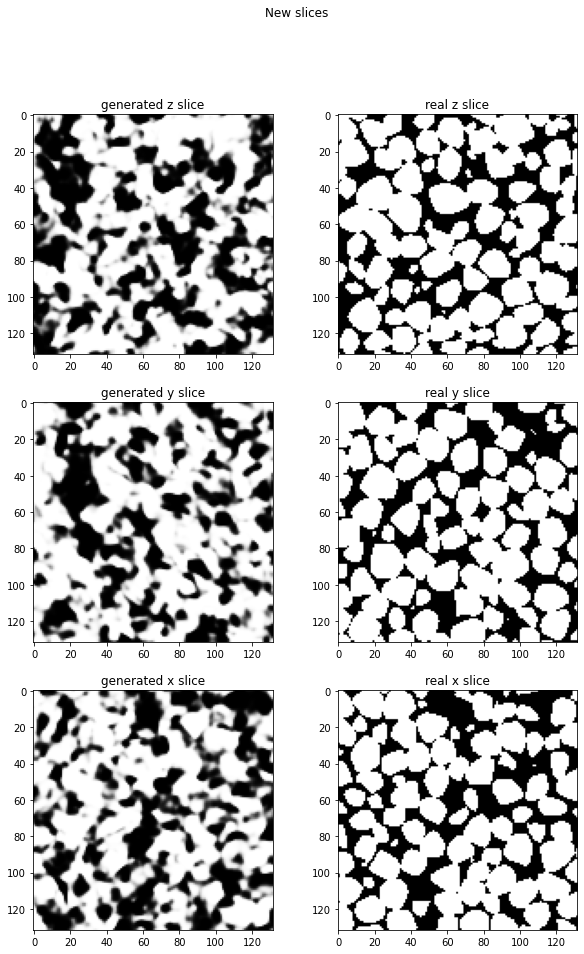

In [19]:
sel_slice = 20

plt.figure(figsize=(10,15))
plt.suptitle('New slices')

sel = (slice(None), slice(None), sel_slice)
plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, idx_plot=1)

sel = (slice(None), sel_slice, slice(None))
plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, axis='y', idx_plot=2)

sel = (sel_slice, slice(None), slice(None))
plot_selected_slices(sel, res_full.transpose(1,0,2), data, mask, axis='x', idx_plot=3)

In [21]:
# save data to npy file

np.save(data_path+'siren', res_full>0.5)